In [1]:
import pandas as pd
from pandas import scatter_matrix
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import fbeta_score, make_scorer, recall_score


from sklearn import preprocessing
from sklearn.preprocessing import  RobustScaler

from sklearn.decomposition import PCA, FastICA

from sklearn.feature_selection import SelectKBest

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn import svm

from random import randint

%matplotlib inline


In [2]:
folds = 4

### Load Dataset

In [3]:
data_iono = pd.read_csv("/home/wanda/master_project/Data/events_clean.csv",index_col=0)
print data_iono.shape

(1048, 34)


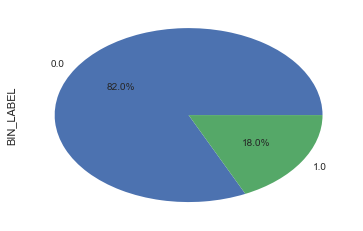

In [4]:
data_iono.BIN_LABEL.value_counts().plot(kind='pie',autopct='%1.1f%%', fontsize=10) 

In [5]:
print data_iono[data_iono.BIN_LABEL==1].shape[0]/folds
print data_iono[data_iono.BIN_LABEL==0].shape[0]/folds

47
214


In [6]:
metadata = ['prn','network','STATIONS','PAIRS', 'ID','YEAR', 'DAY','TIME' ]
labels = ['BIN_LABEL' 'LABEL']
X = data_iono[['A_index',  'C_flare', 'K_index','N_PAIRS', 'N_STATIONS',
               'kurtosis_delay', 'kurtosis_grad', 'max_elevation',
               'max_grad', 'max_phase_delay', 'mean_code_delay', 'mean_elevation',
               'mean_grad', 'mean_phase_delay', 'min_elevation', 'min_grad',
               'min_phase_delay', 'mse', 'new_regions','radio_flux', 'std_grad', 
               'std_phase', 'sunsplot_number','sunspot_area']]

print "Dataset shape: ",X.shape
y_bin, y_classes = data_iono.BIN_LABEL, data_iono.LABEL

Dataset shape:  (1048, 24)


# Binary Classification: Event or not 

sns.set()
cols = ['A_index',  'C_flare', 'K_index','N_PAIRS', 'N_STATIONS',
               'kurtosis_delay', 'kurtosis_grad', 'max_elevation',
               'max_grad', 'max_phase_delay', 'mean_code_delay', 'mean_elevation',
               'mean_grad', 'mean_phase_delay', 'min_elevation', 'min_grad',
               'min_phase_delay', 'mse', 'new_regions','radio_flux', 'std_grad', 
               'std_phase', 'sunsplot_number','sunspot_area', 'LABEL']
sns.pairplot(data = data_iono[cols], hue='BIN_LABEL')

# Testing some machine learning classifiers


**83.2 %  false events**

**16.8 %  true events**

- FP --> Non Ionospheric Event, Labeled as event
- FN --> True Ionospheric Event, Labeled as not events
- TP --> True Ionospheric Event, Labeled as events
- TN --> Non Ionospheric Event, Labeled as not events

In [5]:
f2_scorer = make_scorer(fbeta_score, beta=2)
f2_scorer

recall_scorer = make_scorer(recall_score)
recall_scorer

#http://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/
def fnr_score(y, y_pred):
    tp = float(np.sum(y_pred[y==1]==1))
    fn = float(np.sum(y_pred[y==1]==0))
    fp = float(np.sum(y_pred[y==0]==1))
    tn = float(np.sum(y_pred[y==0]==0))
    fnr = fn/(tp+fn)
    return fnr
          
def tpr_score(y, y_pred):
    tp = float(np.sum(y_pred[y==1]==1) )
    fn = float(np.sum(y_pred[y==1]==0) )
    fp = float(np.sum(y_pred[y==0]==1) )
    tn = float(np.sum(y_pred[y==0]==0) )
    tpr = tp/(tp+fn)
    return tpr
              
fnr_scorer = make_scorer(fnr_score)
tpr_scorer = make_scorer(tpr_score)

# Data transformations and scalers

> Many elements used in the objective function of a learning algorithm (such as the RBF kernel of Support Vector Machines or the l1 and l2 regularizers of linear models) assume that all features are centered around zero and have variance in the same order. If a feature has a variance that is orders of magnitude larger than others, it might dominate the objective function and make the estimator unable to learn from other features correctly as expected.

- Scalar --> zero mean and unit variance.
- Robust scaler --> data with outliers
- Principal Component Analysis -->Singular value decomposition to project on lower dimensional space. 
- T**runcatedSVD --> SVD for Sparse data **

In [6]:
np.sum(X==0)

A_index               0
C_flare             117
K_index              57
N_PAIRS               0
N_STATIONS            0
kurtosis_delay        0
kurtosis_grad         0
max_elevation         0
max_grad              0
max_phase_delay       0
mean_code_delay       0
mean_elevation        0
mean_grad             0
mean_phase_delay      0
min_elevation         0
min_grad              0
min_phase_delay       0
mse                   0
new_regions         480
radio_flux            0
std_grad              0
std_phase             0
sunsplot_number       0
sunspot_area          0
dtype: int64

In [7]:
X_scaled = preprocessing.scale(X) # zero mean, variance 1 
X_scaled.shape

(1048, 24)

In [8]:
robust_scaler = RobustScaler() # Data with outliers
X_robust = robust_scaler.fit_transform(X)
X_robust.shape

(1048, 24)

In [9]:
nc = 20
pca = PCA(n_components = nc)
X_pca = pca.fit_transform(X)
print X_pca.shape

(1048, 20)


In [10]:
nc = 20
pca = FastICA(n_components = nc, tol = 0.001)
X_ica = pca.fit_transform(X)
print X_ica.shape

(1048, 20)


/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/sklearn/decomposition/fastica_.py:116: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


In [11]:
pca = PCA(whiten=True, n_components=nc)
X_pca_w = pca.fit_transform(X)
X_pca_w.shape

(1048, 20)

In [12]:
import time
n_samples = X.shape[0]

*-----------------------------------------------------------------------------------*
## Logistic Regression

solvers : {‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’}, default: ‘liblinear’
Algorithm to use in the optimization problem.


For small datasets, ‘liblinear’ is a good choice, whereas ‘sag’ is
faster for large ones.


**For multiclass problems, only ‘newton-cg’, ‘sag’ and ‘lbfgs’ handle
multinomial loss; ‘liblinear’ is limited to one-versus-rest schemes.
‘newton-cg’, ‘lbfgs’ and ‘sag’ only handle L2 penalty.**


Note that ‘sag’ fast convergence is only guaranteed on features with approximately the same scale. You can preprocess the data with a scaler from sklearn.preprocessing.
New in version 0.17: Stochastic Average Gradient descent solver.

### Solver newton

In [13]:
start = time.time()
clf = LogisticRegression(solver='newton-cg')#,max_iter=500

#Use classifier using cross validation
cv = StratifiedKFold(n_splits=4, random_state=randint(1,100), shuffle=True)
scores = cross_val_score(clf, X, y_bin, cv=cv)#
time_lr = time.time() - start
print "Time: ",time_lr

scores = cross_val_score(clf, X, y_bin, cv=cv, scoring='recall')
print("TPR-Recall: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores: ",scores,"\n"

scores = cross_val_score(clf, X, y_bin, cv=cv, scoring=tpr_scorer)
print("TPR-craft: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores: ",scores,"\n"  

scores = cross_val_score(clf, X, y_bin, cv=cv, scoring='f1')
print("F1-score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores: ",scores,"\n"   

scores = cross_val_score(clf, X, y_bin, cv=cv, scoring=f2_scorer)
print("F2-score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores: ",scores,"\n"  

scores = cross_val_score(clf, X, y_bin, cv=cv, scoring=fnr_scorer)
print("FNR: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores: ",scores,"\n"  


scores = cross_val_score(clf, X, y_bin, cv=cv, scoring='accuracy')
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores: ",scores,"\n"   

scores = cross_val_score(clf, X, y_bin, cv=cv, scoring='precision')
print("Precision: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores: ",scores,"\n"   

Time:  0.58366894722
TPR-Recall: 0.74 (+/- 0.08)
Scores:  [ 0.70833333  0.70212766  0.74468085  0.80851064] 



/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:17: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:18: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:19: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:20: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


TPR-craft: 0.41 (+/- 0.82)
Scores:  [ 0.          0.          0.82061069  0.81992337] 

F1-score: 0.77 (+/- 0.06)
Scores:  [ 0.74725275  0.79518072  0.74468085  0.80851064] 

F2-score: 0.75 (+/- 0.07)
Scores:  [ 0.72340426  0.73660714  0.74468085  0.80851064] 



/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:9: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:10: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:11: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:12: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


FNR: 0.59 (+/- 0.82)
Scores:  [ 1.          1.          0.17938931  0.18007663] 

Accuracy: 0.92 (+/- 0.02)
Scores:  [ 0.91254753  0.9351145   0.90839695  0.93103448] 

Precision: 0.82 (+/- 0.13)
Scores:  [ 0.79069767  0.91666667  0.74468085  0.80851064] 



### Solver lbfgs

In [14]:
#Use classifier using cross validation
start = time.time()
clf = LogisticRegression(solver='lbfgs')#,max_iter=500

#Use classifier using cross validation
cv = StratifiedKFold(n_splits=4, random_state=randint(1,100), shuffle=True)
scores = cross_val_score(clf, X, y_bin, cv=cv)#
time_lr = time.time() - start
print "Time: ",time_lr

scores = cross_val_score(clf, X, y_bin, cv=cv, scoring='recall')
print("TPR-Recall: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores: ",scores,"\n"

scores = cross_val_score(clf, X, y_bin, cv=cv, scoring=tpr_scorer)
print("TPR-craft: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores: ",scores,"\n"  

scores = cross_val_score(clf, X, y_bin, cv=cv, scoring='f1')
print("F1-score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores: ",scores,"\n"   

scores = cross_val_score(clf, X, y_bin, cv=cv, scoring=f2_scorer)
print("F2-score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores: ",scores,"\n"  

scores = cross_val_score(clf, X, y_bin, cv=cv, scoring=fnr_scorer)
print("FNR: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores: ",scores,"\n"  


scores = cross_val_score(clf, X, y_bin, cv=cv, scoring='accuracy')
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores: ",scores,"\n"   

scores = cross_val_score(clf, X, y_bin, cv=cv, scoring='precision')
print("Precision: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores: ",scores,"\n"   

Time:  0.118150949478
TPR-Recall: 0.70 (+/- 0.07)
Scores:  [ 0.6875      0.72340426  0.74468085  0.65957447] 

TPR-craft: 0.66 (+/- 0.78)
Scores:  [ 1.          0.82061069  0.82061069  0.        ] 



/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:17: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:18: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:19: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:20: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


F1-score: 0.74 (+/- 0.07)
Scores:  [ 0.69473684  0.72340426  0.78651685  0.74698795] 

F2-score: 0.72 (+/- 0.06)
Scores:  [ 0.69037657  0.72340426  0.76086957  0.69196429] 

FNR: 0.34 (+/- 0.78)
Scores:  [ 0.          0.17938931  0.17938931  1.        ] 

Accuracy: 0.91 (+/- 0.03)
Scores:  [ 0.88973384  0.90076336  0.92748092  0.91954023] 



/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:9: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:10: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:11: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:12: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


Precision: 0.78 (+/- 0.14)
Scores:  [ 0.70212766  0.72340426  0.83333333  0.86111111] 



In [15]:
#Use classifier using cross validation
start = time.time()
clf = LogisticRegression(solver='liblinear')#,max_iter=500

cv = StratifiedKFold(n_splits=4, random_state=randint(1,100), shuffle=True)
scores = cross_val_score(clf, X, y_bin, cv=cv)#
time_lr = time.time() - start
print "Time: ",time_lr

scores = cross_val_score(clf, X, y_bin, cv=cv, scoring='recall')
print("TPR-Recall: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores: ",scores,"\n"

scores = cross_val_score(clf, X, y_bin, cv=cv, scoring=tpr_scorer)
print("TPR-craft: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores: ",scores,"\n"  

scores = cross_val_score(clf, X, y_bin, cv=cv, scoring='f1')
print("F1-score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores: ",scores,"\n"   

scores = cross_val_score(clf, X, y_bin, cv=cv, scoring=f2_scorer)
print("F2-score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores: ",scores,"\n"  

scores = cross_val_score(clf, X, y_bin, cv=cv, scoring=fnr_scorer)
print("FNR: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores: ",scores,"\n"  


scores = cross_val_score(clf, X, y_bin, cv=cv, scoring='accuracy')
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores: ",scores,"\n"   

scores = cross_val_score(clf, X, y_bin, cv=cv, scoring='precision')
print("Precision: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores: ",scores,"\n"   

Time:  0.128554105759
TPR-Recall: 0.70 (+/- 0.09)
Scores:  [ 0.70833333  0.68085106  0.63829787  0.76595745] 

TPR-craft: 0.41 (+/- 0.82)
Scores:  [ 0.          0.82061069  0.          0.81992337] 



/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:17: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:18: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:19: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:20: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


F1-score: 0.74 (+/- 0.05)
Scores:  [ 0.76404494  0.75294118  0.69767442  0.75789474] 

F2-score: 0.72 (+/- 0.07)
Scores:  [ 0.72961373  0.7079646   0.66079295  0.76271186] 

FNR: 0.59 (+/- 0.82)
Scores:  [ 1.          0.17938931  1.          0.18007663] 



/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:9: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:10: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:11: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:12: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


Accuracy: 0.91 (+/- 0.02)
Scores:  [ 0.92015209  0.91984733  0.90076336  0.91187739] 

Precision: 0.80 (+/- 0.08)
Scores:  [ 0.82926829  0.84210526  0.76923077  0.75      ] 



*-----------------------------------------------------------------------------------*
## Decision Tree Classifier



> **Balance your dataset before training to prevent the tree from being biased toward the classes that are dominant. Class balancing can be done by sampling an equal number of samples from each class, or preferably by normalizing the sum of the sample weights (sample_weight) for each class to the same value. Also note that weight-based pre-pruning criteria, such as min_weight_fraction_leaf, will then be less biased toward dominant classes than criteria that are not aware of the sample weights, like min_samples_leaf.**
*----------------------------------------*
-  A tree with few samples in high dimensional space is very likely to overfit.
**Use PCA, ICA or feature selection**
- Try balancing dataset or play with the *min_weight_fraction_leaf parameter, min_samples_leaf, class_weight*
- try different depth  gridsearch
- different criteria gini and entropy.
- Convert to sparse csc_matrix before calling fit and sparse csr_matrix before calling predict. If matrix is sparse.

Gini with weights and min_weight_fraction_leaf works bestand raw data

In [16]:
from IPython.display import Image 
import pydotplus 

###  Gini normal data

In [17]:
start = time.time()

clf = DecisionTreeClassifier(criterion='gini')
scores = cross_val_score(clf, X, y_bin, cv=cv)

#Use classifier using cross validation
cv = StratifiedKFold(n_splits=4, random_state=randint(1,100), shuffle=True)
scores = cross_val_score(clf, X, y_bin, cv=cv)#
time_lr = time.time() - start
print "Time: ",time_lr

scores = cross_val_score(clf, X, y_bin, cv=cv, scoring='recall')
print("TPR-Recall: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores: ",scores,"\n"

scores = cross_val_score(clf, X, y_bin, cv=cv, scoring=tpr_scorer)
print("TPR-craft: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores: ",scores,"\n"  

scores = cross_val_score(clf, X, y_bin, cv=cv, scoring='f1')
print("F1-score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores: ",scores,"\n"   

scores = cross_val_score(clf, X, y_bin, cv=cv, scoring=f2_scorer)
print("F2-score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores: ",scores,"\n"  

scores = cross_val_score(clf, X, y_bin, cv=cv, scoring=fnr_scorer)
print("FNR: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores: ",scores,"\n"  


scores = cross_val_score(clf, X, y_bin, cv=cv, scoring='accuracy')
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores: ",scores,"\n"   

scores = cross_val_score(clf, X, y_bin, cv=cv, scoring='precision')
print("Precision: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores: ",scores,"\n"   

Time:  0.124033927917
TPR-Recall: 0.66 (+/- 0.11)
Scores:  [ 0.58333333  0.65957447  0.74468085  0.65957447] 

TPR-craft: 0.62 (+/- 0.71)
Scores:  [ 0.          0.82061069  0.82061069  0.81992337] 

F1-score: 0.68 (+/- 0.12)
Scores:  [ 0.69767442  0.68888889  0.74226804  0.58      ] 



/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:17: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:18: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:19: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:20: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


F2-score: 0.66 (+/- 0.12)
Scores:  [ 0.6223176   0.65217391  0.75313808  0.60165975] 

FNR: 0.38 (+/- 0.71)
Scores:  [ 1.          0.17938931  0.17938931  0.18007663] 

Accuracy: 0.89 (+/- 0.05)
Scores:  [ 0.8973384   0.90076336  0.90839695  0.84291188] 



/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:9: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:10: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:11: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:12: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


Precision: 0.68 (+/- 0.17)
Scores:  [ 0.70454545  0.76190476  0.72        0.54      ] 



### Scaling to zero mean and variance 1

In [18]:
#no hace mucho escalar
start = time.time()
clf = DecisionTreeClassifier(criterion='gini')

#Use classifier using cross validation
cv = StratifiedKFold(n_splits=4, random_state=randint(1,100), shuffle=True)
scores = cross_val_score(clf, X, y_bin, cv=cv)#
time_lr = time.time() - start
print "Time: ",time_lr

scores = cross_val_score(clf, X, y_bin, cv=cv, scoring='recall')
print("TPR-Recall: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores: ",scores,"\n"

scores = cross_val_score(clf, X, y_bin, cv=cv, scoring=tpr_scorer)
print("TPR-craft: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores: ",scores,"\n"  

scores = cross_val_score(clf, X, y_bin, cv=cv, scoring='f1')
print("F1-score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores: ",scores,"\n"   

scores = cross_val_score(clf, X, y_bin, cv=cv, scoring=f2_scorer)
print("F2-score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores: ",scores,"\n"  

scores = cross_val_score(clf, X, y_bin, cv=cv, scoring=fnr_scorer)
print("FNR: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores: ",scores,"\n"  


scores = cross_val_score(clf, X, y_bin, cv=cv, scoring='accuracy')
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores: ",scores,"\n"   

scores = cross_val_score(clf, X, y_bin, cv=cv, scoring='precision')
print("Precision: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores: ",scores,"\n"   

Time:  0.0817620754242
TPR-Recall: 0.67 (+/- 0.19)
Scores:  [ 0.8125      0.59574468  0.57446809  0.68085106] 

TPR-craft: 0.41 (+/- 0.82)
Scores:  [ 0.81749049  0.82061069  0.          0.        ] 

F1-score: 0.63 (+/- 0.13)
Scores:  [ 0.66666667  0.56179775  0.57446809  0.7173913 ] 



/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:17: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:18: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:19: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:20: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:9: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:10: FutureWarning: in the future, 

F2-score: 0.64 (+/- 0.19)
Scores:  [ 0.76771654  0.58951965  0.51948052  0.69565217] 

FNR: 0.59 (+/- 0.82)
Scores:  [ 0.18250951  0.17938931  1.          1.        ] 

Accuracy: 0.87 (+/- 0.04)
Scores:  [ 0.87452471  0.83969466  0.86259542  0.89655172] 

Precision: 0.63 (+/- 0.11)
Scores:  [ 0.62068966  0.65789474  0.55102041  0.70212766] 



### Reducing components

In [19]:
start = time.time()
clf = DecisionTreeClassifier(criterion='gini')
#pocas componentes dañan el arbol!

#Use classifier using cross validation
cv = StratifiedKFold(n_splits=4, random_state=randint(1,100), shuffle=True)
scores = cross_val_score(clf, X, y_bin, cv=cv)#
time_lr = time.time() - start
print "Time: ",time_lr

scores = cross_val_score(clf, X, y_bin, cv=cv, scoring='recall')
print("TPR-Recall: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores: ",scores,"\n"

scores = cross_val_score(clf, X, y_bin, cv=cv, scoring=tpr_scorer)
print("TPR-craft: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores: ",scores,"\n"  

scores = cross_val_score(clf, X, y_bin, cv=cv, scoring='f1')
print("F1-score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores: ",scores,"\n"   

scores = cross_val_score(clf, X, y_bin, cv=cv, scoring=f2_scorer)
print("F2-score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores: ",scores,"\n"  

scores = cross_val_score(clf, X, y_bin, cv=cv, scoring=fnr_scorer)
print("FNR: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores: ",scores,"\n"  


scores = cross_val_score(clf, X, y_bin, cv=cv, scoring='accuracy')
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores: ",scores,"\n"   

scores = cross_val_score(clf, X, y_bin, cv=cv, scoring='precision')
print("Precision: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores: ",scores,"\n"   

Time:  0.0609250068665
TPR-Recall: 0.66 (+/- 0.09)
Scores:  [ 0.58333333  0.70212766  0.68085106  0.65957447] 

TPR-craft: 0.45 (+/- 0.92)
Scores:  [ 0.81749049  1.          0.          0.        ] 

F1-score: 0.66 (+/- 0.06)
Scores:  [ 0.61052632  0.68888889  0.66666667  0.68131868] 

F2-score: 0.67 (+/- 0.02)
Scores:  [ 0.6626506   0.69264069  0.66239316  0.66810345] 



/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:17: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:18: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:19: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:20: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:9: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:10: FutureWarning: in the future, 

FNR: 0.55 (+/- 0.92)
Scores:  [ 0.18250951  0.          1.          1.        ] 

Accuracy: 0.88 (+/- 0.04)
Scores:  [ 0.85171103  0.90458015  0.88549618  0.8697318 ] 

Precision: 0.67 (+/- 0.11)
Scores:  [ 0.58        0.72727273  0.70833333  0.68085106] 



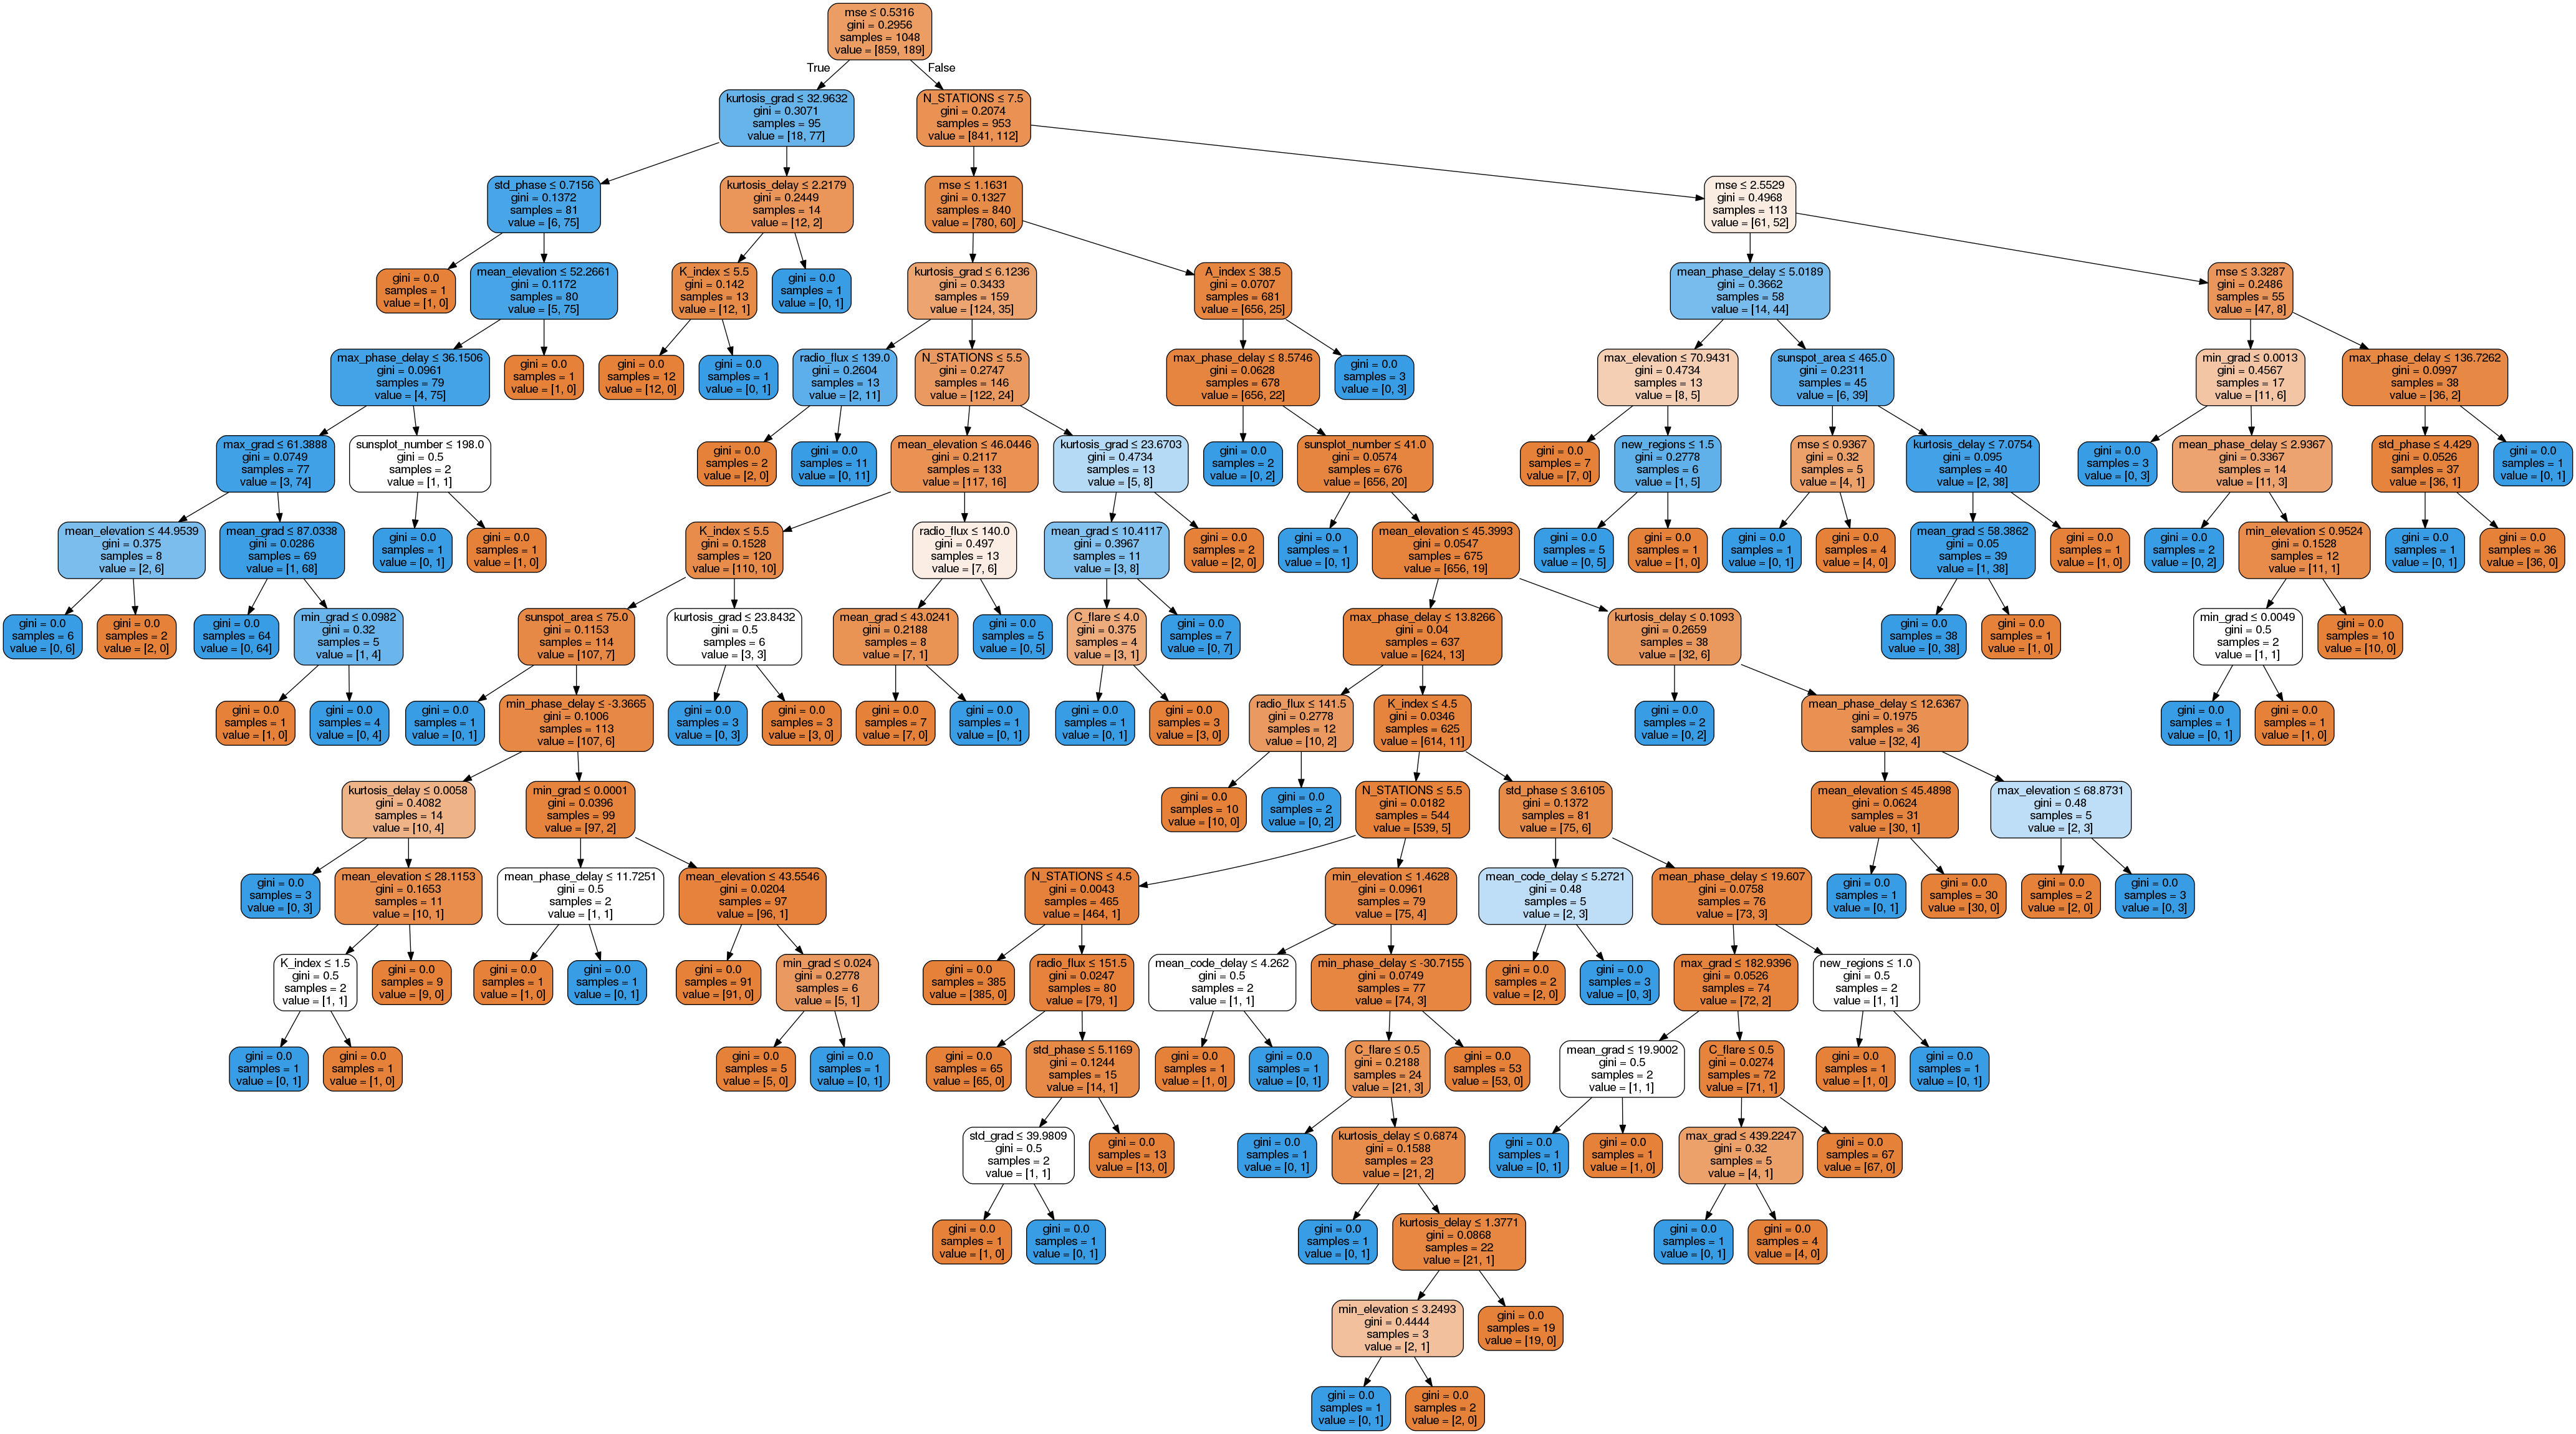

In [21]:
#Visualice tree!
clf.fit(X,y_bin)
dot_data = export_graphviz(clf, out_file=None, 
                         feature_names=X.columns,  
                         #class_names=iris.target_names,  
                         filled=True, rounded=True,  
                         special_characters=True)  


graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())  

### Playing with parameters to balance out

In [22]:
start = time.time()
clf = DecisionTreeClassifier(criterion='gini',class_weight={0:.2, 1:1.},min_weight_fraction_leaf=.2) #0.5
#Use classifier using cross validation
cv = StratifiedKFold(n_splits=4, random_state=randint(1,100), shuffle=True)
scores = cross_val_score(clf, X, y_bin, cv=cv)#
time_lr = time.time() - start
print "Time: ",time_lr

scores = cross_val_score(clf, X, y_bin, cv=cv, scoring='recall')
print("TPR-Recall: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores: ",scores,"\n"

scores = cross_val_score(clf, X, y_bin, cv=cv, scoring=tpr_scorer)
print("TPR-craft: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores: ",scores,"\n"  

scores = cross_val_score(clf, X, y_bin, cv=cv, scoring='f1')
print("F1-score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores: ",scores,"\n"   

scores = cross_val_score(clf, X, y_bin, cv=cv, scoring=f2_scorer)
print("F2-score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores: ",scores,"\n"  

scores = cross_val_score(clf, X, y_bin, cv=cv, scoring=fnr_scorer)
print("FNR: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores: ",scores,"\n"  


scores = cross_val_score(clf, X, y_bin, cv=cv, scoring='accuracy')
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores: ",scores,"\n"   

scores = cross_val_score(clf, X, y_bin, cv=cv, scoring='precision')
print("Precision: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores: ",scores,"\n"   

Time:  0.0417830944061
TPR-Recall: 0.74 (+/- 0.08)
Scores:  [ 0.70833333  0.80851064  0.74468085  0.70212766] 

TPR-craft: 0.50 (+/- 0.84)
Scores:  [ 0.18250951  0.          0.82061069  1.        ] 

F1-score: 0.53 (+/- 0.07)
Scores:  [ 0.49275362  0.50331126  0.54263566  0.57894737] 

F2-score: 0.64 (+/- 0.04)
Scores:  [ 0.60283688  0.65068493  0.64814815  0.64705882] 

FNR: 0.50 (+/- 0.84)
Scores:  [ 0.81749049  1.          0.17938931  0.        ] 

Accuracy: 0.76 (+/- 0.08)
Scores:  [ 0.7338403   0.71374046  0.77480916  0.81609195] 

Precision: 0.42 (+/- 0.10)
Scores:  [ 0.37777778  0.36538462  0.42682927  0.49253731] 



/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:17: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:18: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:19: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:20: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:9: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:10: FutureWarning: in the future, 

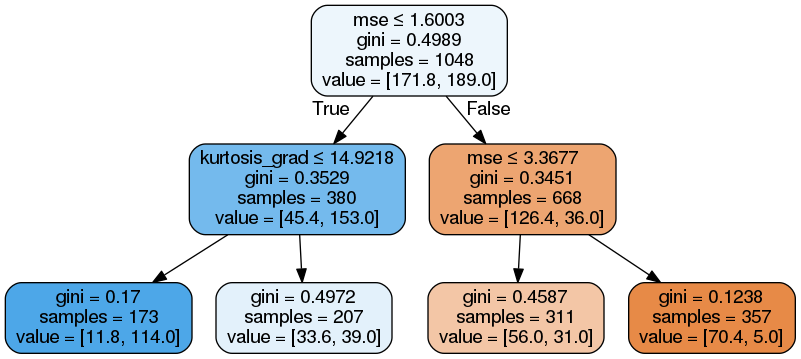

In [23]:
clf.fit(X,y_bin)
dot_data = export_graphviz(clf, out_file=None, 
                         feature_names=X.columns,  
                         #class_names=iris.target_names,  
                         filled=True, rounded=True,  
                         special_characters=True)  


graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())  

### Entropy criteria

In [24]:
#Use classifier using cross validation
start = time.time()
clf = DecisionTreeClassifier(criterion='entropy')

#Use classifier using cross validation
cv = StratifiedKFold(n_splits=4, random_state=randint(1,100), shuffle=True)
scores = cross_val_score(clf, X, y_bin, cv=cv)#
time_lr = time.time() - start
print "Time: ",time_lr

scores = cross_val_score(clf, X, y_bin, cv=cv, scoring='recall')
print("TPR-Recall: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores: ",scores,"\n"

scores = cross_val_score(clf, X, y_bin, cv=cv, scoring=tpr_scorer)
print("TPR-craft: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores: ",scores,"\n"  

scores = cross_val_score(clf, X, y_bin, cv=cv, scoring='f1')
print("F1-score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores: ",scores,"\n"   

scores = cross_val_score(clf, X, y_bin, cv=cv, scoring=f2_scorer)
print("F2-score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores: ",scores,"\n"  

scores = cross_val_score(clf, X, y_bin, cv=cv, scoring=fnr_scorer)
print("FNR: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores: ",scores,"\n"  


scores = cross_val_score(clf, X, y_bin, cv=cv, scoring='accuracy')
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores: ",scores,"\n"   

scores = cross_val_score(clf, X, y_bin, cv=cv, scoring='precision')
print("Precision: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores: ",scores,"\n"   

Time:  0.0737209320068
TPR-Recall: 0.63 (+/- 0.18)
Scores:  [ 0.5         0.61702128  0.65957447  0.74468085] 

TPR-craft: 0.00 (+/- 0.00)
Scores:  [ 0.  0.  0.  0.] 



/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:17: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:18: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:19: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:20: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


F1-score: 0.65 (+/- 0.10)
Scores:  [ 0.6         0.63736264  0.62264151  0.72727273] 

F2-score: 0.63 (+/- 0.15)
Scores:  [ 0.54112554  0.5720339   0.6504065   0.73839662] 

FNR: 1.00 (+/- 0.00)
Scores:  [ 1.  1.  1.  1.] 

Accuracy: 0.86 (+/- 0.05)
Scores:  [ 0.84410646  0.86641221  0.84351145  0.90038314] 

Precision: 0.65 (+/- 0.17)
Scores:  [ 0.65        0.61702128  0.54237288  0.77272727] 



/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:9: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:10: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:11: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:12: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


In [25]:
#Use classifier using cross validation
start = time.time()
clf = DecisionTreeClassifier(criterion='entropy',class_weight={0:.2, 1:1.},min_weight_fraction_leaf=.2) #0.5

#Use classifier using cross validation
cv = StratifiedKFold(n_splits=4, random_state=randint(1,100), shuffle=True)
scores = cross_val_score(clf, X, y_bin, cv=cv)#
time_lr = time.time() - start
print "Time: ",time_lr

scores = cross_val_score(clf, X, y_bin, cv=cv, scoring='recall')
print("TPR-Recall: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores: ",scores,"\n"

scores = cross_val_score(clf, X, y_bin, cv=cv, scoring=tpr_scorer)
print("TPR-craft: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores: ",scores,"\n"  

scores = cross_val_score(clf, X, y_bin, cv=cv, scoring='f1')
print("F1-score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores: ",scores,"\n"   

scores = cross_val_score(clf, X, y_bin, cv=cv, scoring=f2_scorer)
print("F2-score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores: ",scores,"\n"  

scores = cross_val_score(clf, X, y_bin, cv=cv, scoring=fnr_scorer)
print("FNR: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores: ",scores,"\n"  


scores = cross_val_score(clf, X, y_bin, cv=cv, scoring='accuracy')
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores: ",scores,"\n"   

scores = cross_val_score(clf, X, y_bin, cv=cv, scoring='precision')
print("Precision: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores: ",scores,"\n"   

Time:  0.0361239910126
TPR-Recall: 0.71 (+/- 0.13)
Scores:  [ 0.64583333  0.76595745  0.65957447  0.78723404] 

TPR-craft: 0.41 (+/- 0.82)
Scores:  [ 0.          0.82061069  0.82061069  0.        ] 

F1-score: 0.56 (+/- 0.14)
Scores:  [ 0.45255474  0.60504202  0.55357143  0.63247863] 

F2-score: 0.64 (+/- 0.13)
Scores:  [ 0.55160142  0.69230769  0.61264822  0.71705426] 

FNR: 0.59 (+/- 0.82)
Scores:  [ 1.          0.17938931  0.17938931  1.        ] 



/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:17: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:18: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:19: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:20: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:9: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:10: FutureWarning: in the future, 

Accuracy: 0.79 (+/- 0.09)
Scores:  [ 0.7148289   0.82061069  0.80916031  0.83524904] 

Precision: 0.46 (+/- 0.14)
Scores:  [ 0.34831461  0.5         0.47692308  0.52857143] 



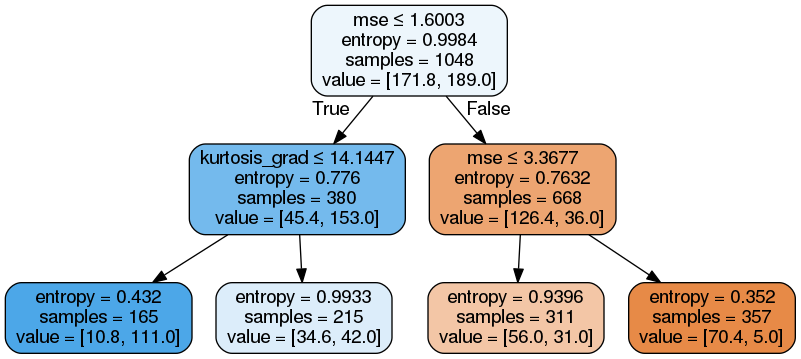

In [26]:
#Visualice tree!
clf.fit(X,y_bin)
dot_data = export_graphviz(clf, out_file=None, 
                         feature_names=X.columns,  
                         #class_names=iris.target_names,  
                         filled=True, rounded=True,  
                         special_characters=True)  


graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())  

*-----------------------------------------------------------------------------------*
## Linear Discriminant Analysis

- linear and quadratic discriminant analysis use Gaussian densities;


Solver to use, possible values:
<a href="https://ocw.mit.edu/courses/mathematics/18-06-linear-algebra-spring-2010/video-lectures/lecture-29-singular-value-decomposition/">‘svd’</a>: Singular value decomposition (default). Does not compute the covariance matrix, therefore this solver is recommended for data with a large number of features.
‘lsqr’: Least squares solution, can be combined with shrinkage.
‘eigen’: Eigenvalue decomposition, can be combined with shrinkage.

- shrinkage: a tool to improve estimation of covariance matrices in situations where the number of training samples is small compared to the number of features

**transform(X)**	Project data to maximize class separation.

### Singular Value decomposition

In [27]:
#maloo
start = time.time()
clf = LinearDiscriminantAnalysis(solver = 'svd')

#Use classifier using cross validation
cv = StratifiedKFold(n_splits=4, random_state=randint(1,100), shuffle=True)
scores = cross_val_score(clf, X, y_bin, cv=cv)#
time_lr = time.time() - start
print "Time: ",time_lr

scores = cross_val_score(clf, X, y_bin, cv=cv, scoring='recall')
print("TPR-Recall: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores: ",scores,"\n"

scores = cross_val_score(clf, X, y_bin, cv=cv, scoring=tpr_scorer)
print("TPR-craft: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores: ",scores,"\n"  

scores = cross_val_score(clf, X, y_bin, cv=cv, scoring='f1')
print("F1-score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores: ",scores,"\n"   

scores = cross_val_score(clf, X, y_bin, cv=cv, scoring=f2_scorer)
print("F2-score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores: ",scores,"\n"  

scores = cross_val_score(clf, X, y_bin, cv=cv, scoring=fnr_scorer)
print("FNR: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores: ",scores,"\n"  


scores = cross_val_score(clf, X, y_bin, cv=cv, scoring='accuracy')
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores: ",scores,"\n"   

scores = cross_val_score(clf, X, y_bin, cv=cv, scoring='precision')
print("Precision: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores: ",scores,"\n"   

Time:  0.031683921814
TPR-Recall: 0.46 (+/- 0.17)
Scores:  [ 0.41666667  0.42553191  0.38297872  0.59574468] 

TPR-craft: 0.50 (+/- 0.84)
Scores:  [ 0.18250951  0.82061069  1.          0.        ] 

F1-score: 0.55 (+/- 0.17)
Scores:  [ 0.49382716  0.50632911  0.5         0.69135802] 

F2-score: 0.49 (+/- 0.17)
Scores:  [ 0.44444444  0.45454545  0.42253521  0.63063063] 

FNR: 0.50 (+/- 0.84)
Scores:  [ 0.81749049  0.17938931  0.          1.        ] 

Accuracy: 0.87 (+/- 0.05)
Scores:  [ 0.84410646  0.85114504  0.86259542  0.90421456] 

Precision: 0.69 (+/- 0.17)
Scores:  [ 0.60606061  0.625       0.72        0.82352941] 



/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:17: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:18: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:19: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:20: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:9: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:10: FutureWarning: in the future, 

**warnings.warn("Variables are collinear.")**

In [28]:
#Plot new components from LDA
clf.fit(X,y_bin)
X_transformed = clf.transform(X)
print X_transformed.shape

(1048, 1)


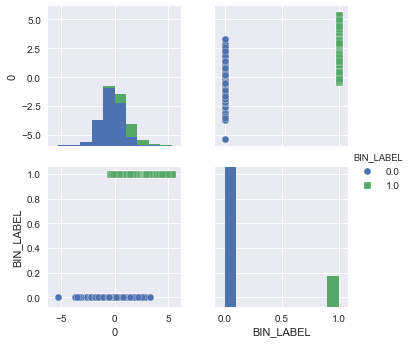

In [29]:
X_pd_trans = pd.DataFrame(X_transformed)
X_pd_trans['BIN_LABEL'] = y_bin.values

sns.set()
sns.pairplot(data = X_pd_trans, hue='BIN_LABEL',markers=["o", "s"])
#only 2 projections ! what!

In [30]:
#maloo
start = time.time()
clf = LinearDiscriminantAnalysis(solver='eigen', shrinkage='auto')

#Use classifier using cross validation
cv = StratifiedKFold(n_splits=4, random_state=randint(1,100), shuffle=True)
scores = cross_val_score(clf, X, y_bin, cv=cv)#
time_lr = time.time() - start
print "Time: ",time_lr

scores = cross_val_score(clf, X, y_bin, cv=cv, scoring='recall')
print("TPR-Recall: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores: ",scores,"\n"

scores = cross_val_score(clf, X, y_bin, cv=cv, scoring=tpr_scorer)
print("TPR-craft: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores: ",scores,"\n"  

scores = cross_val_score(clf, X, y_bin, cv=cv, scoring='f1')
print("F1-score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores: ",scores,"\n"   

scores = cross_val_score(clf, X, y_bin, cv=cv, scoring=f2_scorer)
print("F2-score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores: ",scores,"\n"  

scores = cross_val_score(clf, X, y_bin, cv=cv, scoring=fnr_scorer)
print("FNR: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores: ",scores,"\n"  


scores = cross_val_score(clf, X, y_bin, cv=cv, scoring='accuracy')
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores: ",scores,"\n"   

scores = cross_val_score(clf, X, y_bin, cv=cv, scoring='precision')
print("Precision: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores: ",scores,"\n"   

Time:  0.116227865219
TPR-Recall: 0.82 (+/- 0.16)
Scores:  [ 0.70833333  0.78723404  0.93617021  0.82978723] 

TPR-craft: 0.91 (+/- 0.18)
Scores:  [ 1.          1.          0.82061069  0.81992337] 

F1-score: 0.67 (+/- 0.15)
Scores:  [ 0.57627119  0.64347826  0.77876106  0.66666667] 

F2-score: 0.75 (+/- 0.16)
Scores:  [ 0.64885496  0.72265625  0.86614173  0.75581395] 

FNR: 0.09 (+/- 0.18)
Scores:  [ 0.          0.          0.17938931  0.18007663] 

Accuracy: 0.85 (+/- 0.07)
Scores:  [ 0.80988593  0.84351145  0.90458015  0.85057471] 

Precision: 0.56 (+/- 0.13)
Scores:  [ 0.48571429  0.54411765  0.66666667  0.55714286] 



/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:17: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:18: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:19: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:20: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:9: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:10: FutureWarning: in the future, 

*-----------------------------------------------------------------------------------*
## Quadratic Discriminant Analysis

- store_covariances : boolean
    If True the covariance matrices are computed and stored in the
    `self.covariances_` attribute.

In [31]:

start = time.time()
clf = QuadraticDiscriminantAnalysis()

#Use classifier using cross validation
cv = StratifiedKFold(n_splits=4, random_state=randint(1,100), shuffle=True)
scores = cross_val_score(clf, X, y_bin, cv=cv)#
time_lr = time.time() - start
print "Time: ",time_lr

scores = cross_val_score(clf, X, y_bin, cv=cv, scoring='recall')
print("TPR-Recall: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores: ",scores,"\n"

scores = cross_val_score(clf, X, y_bin, cv=cv, scoring=tpr_scorer)
print("TPR-craft: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores: ",scores,"\n"  

scores = cross_val_score(clf, X, y_bin, cv=cv, scoring='f1')
print("F1-score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores: ",scores,"\n"   

scores = cross_val_score(clf, X, y_bin, cv=cv, scoring=f2_scorer)
print("F2-score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores: ",scores,"\n"  

scores = cross_val_score(clf, X, y_bin, cv=cv, scoring=fnr_scorer)
print("FNR: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores: ",scores,"\n"  


scores = cross_val_score(clf, X, y_bin, cv=cv, scoring='accuracy')
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores: ",scores,"\n"   

scores = cross_val_score(clf, X, y_bin, cv=cv, scoring='precision')
print("Precision: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores: ",scores,"\n"   

Time:  0.0264921188354
TPR-Recall: 0.87 (+/- 0.05)
Scores:  [ 0.83333333  0.89361702  0.89361702  0.85106383] 

TPR-craft: 0.82 (+/- 0.00)
Scores:  [ 0.81749049  0.82061069  0.82061069  0.81992337] 

F1-score: 0.63 (+/- 0.03)
Scores:  [ 0.64516129  0.6         0.63157895  0.625     ] 

F2-score: 0.75 (+/- 0.02)
Scores:  [ 0.74626866  0.74733096  0.76642336  0.74349442] 

FNR: 0.18 (+/- 0.00)
Scores:  [ 0.18250951  0.17938931  0.17938931  0.18007663] 

Accuracy: 0.81 (+/- 0.03)
Scores:  [ 0.83269962  0.78625954  0.8129771   0.81609195] 

Precision: 0.49 (+/- 0.05)
Scores:  [ 0.52631579  0.4516129   0.48837209  0.49382716] 



/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:17: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:18: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:19: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:20: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:9: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:10: FutureWarning: in the future, 

*-----------------------------------------------------------------------------------*
## Suppor Vector Machines

> class_weight : {dict, 'balanced'}, optional
    Set the parameter C of class i to class_weight[i]*C for
    SVC. If not given, all classes are supposed to have
    weight one.
    **The "balanced" mode uses the values of y to automatically adjust
    weights inversely proportional to class frequencies in the input data
    as ``n_samples / (n_classes * np.bincount(y))``**

In [32]:
start = time.time()
clf = svm.SVC(kernel='linear') #lentos

#Use classifier using cross validation
cv = StratifiedKFold(n_splits=4, random_state=randint(1,100), shuffle=True)
scores = cross_val_score(clf, X, y_bin, cv=cv)#
time_lr = time.time() - start
print "Time: ",time_lr

scores = cross_val_score(clf, X, y_bin, cv=cv, scoring='recall')
print("TPR-Recall: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores: ",scores,"\n"

scores = cross_val_score(clf, X, y_bin, cv=cv, scoring=tpr_scorer)
print("TPR-craft: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores: ",scores,"\n"  

scores = cross_val_score(clf, X, y_bin, cv=cv, scoring='f1')
print("F1-score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores: ",scores,"\n"   

scores = cross_val_score(clf, X, y_bin, cv=cv, scoring=f2_scorer)
print("F2-score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores: ",scores,"\n"  

scores = cross_val_score(clf, X, y_bin, cv=cv, scoring=fnr_scorer)
print("FNR: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores: ",scores,"\n"  


scores = cross_val_score(clf, X, y_bin, cv=cv, scoring='accuracy')
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores: ",scores,"\n"   

scores = cross_val_score(clf, X, y_bin, cv=cv, scoring='precision')
print("Precision: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores: ",scores,"\n"   

Time:  375.098812103
TPR-Recall: 0.71 (+/- 0.09)
Scores:  [ 0.77083333  0.68085106  0.65957447  0.74468085] 



/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:17: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:18: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:19: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:20: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


TPR-craft: 0.41 (+/- 0.82)
Scores:  [ 0.          0.82061069  0.          0.81992337] 

F1-score: 0.75 (+/- 0.06)
Scores:  [ 0.79569892  0.75294118  0.70454545  0.75268817] 

F2-score: 0.73 (+/- 0.08)
Scores:  [ 0.78059072  0.7079646   0.6768559   0.74786325] 



/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:9: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:10: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:11: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:12: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


FNR: 0.59 (+/- 0.82)
Scores:  [ 1.          0.17938931  1.          0.18007663] 

Accuracy: 0.92 (+/- 0.02)
Scores:  [ 0.92775665  0.91984733  0.90076336  0.91187739] 

Precision: 0.80 (+/- 0.08)
Scores:  [ 0.82222222  0.84210526  0.75609756  0.76086957] 



### Kernel rbf

In [33]:
start = time.time()
clf = svm.SVC(kernel='rbf', C=0.05,class_weight='balanced')#C=0.05 class_weight='balanced'

#Use classifier using cross validation
cv = StratifiedKFold(n_splits=4, random_state=randint(1,100), shuffle=True)
scores = cross_val_score(clf, X, y_bin, cv=cv)#
time_lr = time.time() - start
print "Time: ",time_lr

scores = cross_val_score(clf, X, y_bin, cv=cv, scoring='recall')
print("TPR-Recall: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores: ",scores,"\n"

scores = cross_val_score(clf, X, y_bin, cv=cv, scoring=tpr_scorer)
print("TPR-craft: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores: ",scores,"\n"  

scores = cross_val_score(clf, X, y_bin, cv=cv, scoring='f1')
print("F1-score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores: ",scores,"\n"   

scores = cross_val_score(clf, X, y_bin, cv=cv, scoring=f2_scorer)
print("F2-score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores: ",scores,"\n"  

scores = cross_val_score(clf, X, y_bin, cv=cv, scoring=fnr_scorer)
print("FNR: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores: ",scores,"\n"  


scores = cross_val_score(clf, X, y_bin, cv=cv, scoring='accuracy')
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores: ",scores,"\n"   

scores = cross_val_score(clf, X, y_bin, cv=cv, scoring='precision')
print("Precision: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores: ",scores,"\n"   

Time:  0.168165922165
TPR-Recall: 0.00 (+/- 0.00)
Scores:  [ 0.  0.  0.  0.] 

TPR-craft: 0.00 (+/- 0.00)
Scores:  [ 0.  0.  0.  0.] 



/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:17: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:18: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:19: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:20: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


F1-score: 0.00 (+/- 0.00)
Scores:  [ 0.  0.  0.  0.] 

F2-score: 0.00 (+/- 0.00)
Scores:  [ 0.  0.  0.  0.] 

FNR: 1.00 (+/- 0.00)
Scores:  [ 1.  1.  1.  1.] 



/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:9: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:10: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:11: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:12: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


Accuracy: 0.82 (+/- 0.00)
Scores:  [ 0.81749049  0.82061069  0.82061069  0.81992337] 

Precision: 0.00 (+/- 0.00)
Scores:  [ 0.  0.  0.  0.] 



/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


### Kernel poly

In [34]:
start = time.time()#lento*
clf = svm.SVC(kernel='poly', C=1)

#Use classifier using cross validation
cv = StratifiedKFold(n_splits=4, random_state=randint(1,100), shuffle=True)
scores = cross_val_score(clf, X, y_bin, cv=cv)#
time_lr = time.time() - start
print "Time: ",time_lr

scores = cross_val_score(clf, X, y_bin, cv=cv, scoring='recall')
print("TPR-Recall: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores: ",scores,"\n"

scores = cross_val_score(clf, X, y_bin, cv=cv, scoring=tpr_scorer)
print("TPR-craft: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores: ",scores,"\n"  

scores = cross_val_score(clf, X, y_bin, cv=cv, scoring='f1')
print("F1-score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores: ",scores,"\n"   

scores = cross_val_score(clf, X, y_bin, cv=cv, scoring=f2_scorer)
print("F2-score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores: ",scores,"\n"  

scores = cross_val_score(clf, X, y_bin, cv=cv, scoring=fnr_scorer)
print("FNR: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores: ",scores,"\n"  


scores = cross_val_score(clf, X, y_bin, cv=cv, scoring='accuracy')
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores: ",scores,"\n"   

scores = cross_val_score(clf, X, y_bin, cv=cv, scoring='precision')
print("Precision: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores: ",scores,"\n"   

Time:  1167.74594092
TPR-Recall: 0.72 (+/- 0.13)
Scores:  [ 0.75        0.61702128  0.78723404  0.72340426] 



/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:17: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:18: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:19: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:20: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


TPR-craft: 0.29 (+/- 0.83)
Scores:  [ 1.          0.17938931  0.          0.        ] 

F1-score: 0.66 (+/- 0.06)
Scores:  [ 0.70588235  0.65168539  0.64912281  0.61818182] 

F2-score: 0.69 (+/- 0.08)
Scores:  [ 0.73170732  0.63043478  0.7254902   0.67729084] 



/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:9: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:10: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:11: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/home/wanda/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:12: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


FNR: 0.71 (+/- 0.83)
Scores:  [ 0.          0.82061069  1.          1.        ] 

Accuracy: 0.86 (+/- 0.04)
Scores:  [ 0.88593156  0.88167939  0.84732824  0.83908046] 

Precision: 0.61 (+/- 0.13)
Scores:  [ 0.66666667  0.69047619  0.55223881  0.53968254] 



**Anotations**

Valor F de anova -->http://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection

http://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection

http://www.faqs.org/faqs/ai-faq/neural-nets/part2/section-16.html

http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html#sklearn.feature_selection.SelectKBest

http://scikit-learn.org/stable/modules/preprocessing.html#preprocessing scalar variables

Dont use only scikit learn, look at statsmodels.http://www.statsmodels.org/stable/index.html

There are no categorical features
analisis multivariable! anova Then Make anova?
#Discriminant analisys?
http://scikit-learn.org/stable/auto_examples/plot_multilabel.html#sphx-glr-auto-examples-plot-multilabel-py
http://scikit-learn.org/stable/modules/lda_qda.html

Other classifiers  
- Gaussian Process Classification
- Neural network models (supervised)

Other decompositions 
http://scikit-learn.org/stable/auto_examples/applications/topics_extraction_with_nmf_lda.html


Plotting categorical data
http://seaborn.pydata.org/tutorial/categorical.html#statistical-estimation-within-categories

Correlation coeficient 
http://stattrek.com/statistics/correlation.aspx

Learning curves http://scikit-learn.org/stable/modules/learning_curve.html
http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

Model evaluating ! http://scikit-learn.org/stable/modules/model_evaluation.html#model-evaluation

In [35]:
#038 

# Dataset info 

**Metadata** 

- Day
- Year
- event ID

### Predictor variables
----------------------

- number of stations  **Cuantitativo**
- number of pairs  **Cuantitativo**
- mean elevation **Cuantitativo**
- lowest elevation **Cuantitativo**
- biggest elevation **Cuantitativo**

** Double frequency phase_delay signal information **

- Phase Delay mean **for each station** **Cuantitativo**
- Phase Delay standar deviation **Cuantitativo**
- Phase Delay max **Cuantitativo**
- Phase Delay min **Cuantitativo**
- Phase Delay std **Cuantitativo**
- Phase Delay kurtosis **Cuantitativo**
- Code Delay mean **Cuantitativo**
- Mean squared error between code and phase **Cuantitativo**


**Gradient signal information**


- Kurtosis mean **Cuantitativo**
- Gradient mean **Cuantitativo**
- Gradient max **Cuantitativo**
- Gradient min **Cuantitativo**
- **Outliers detected** 
-  **Segments descriptor ? **


**Space weather data**


- Kp index (Every 3 hours) **Cuantitativo**
- A index (Daily) **Cuantitativo**
- Sunspot number **Cuantitativo**
- Sunspot area **Cuantitativo**
- Radio Flux Penticton 10.7 cm   **Cuantitativo**
-  X-Ray flux flares c y s **Cuantitativo**
-------------------------------

### Original Classes
**True**
- Gradients with few peaks (conus). **(1)**
- Gradients for scintillation (regme) are very varying. **(2)**

**False**
- Short arcs that create high variations on the substraction.**(3)**
- Outliers in one station (faulty for some reason) creating false gradient with all the neighbours.**(4)**
- Outliers in all stations at some time.**(5)**

There's very few elements on classes 4, 5 so we can add them to class 3.